In [1]:
import tensorflow as tf
import keras
import os
import keras_tuner as kt

## Create label dictionary
Since the price buckets may change, we'll create a dictionary to map the price buckets to a prettier format

In [3]:
# Get the buckets based on sub-folders of `buckets`
buckets = [f for f in os.listdir('buckets') if os.path.isdir(os.path.join('buckets', f))]

# Create a dictionary of classes where the key is the class name and the value is a formatted string of the class name
classes = {bucket: '$' + bucket.replace('_', '-$').title() for bucket in buckets}
# Make a label dict of the clases sorted by key, with the values
label_dict = [v for k, v in sorted(classes.items(), key=lambda item: item[0])]
label_dict

['$10-$15',
 '$15-$20',
 '$20-$25',
 '$25-$30',
 '$30-$35',
 '$35-$40',
 '$40-$45',
 '$45-$50']

## Getting the data
We'll start by loading the data from the `buckets` folder

In [4]:
image_dim = 256

In [5]:
price_data = keras.utils.image_dataset_from_directory("buckets",
                                                      labels="inferred",
                                                      label_mode="int",
                                                      image_size=(image_dim,image_dim),
                                                      batch_size=None)
price_data.cardinality()

Found 1639 files belonging to 8 classes.


2024-04-19 13:24:46.835222: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-19 13:24:46.835259: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-19 13:24:46.835283: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-19 13:24:46.835309: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-19 13:24:46.835334: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<tf.Tensor: shape=(), dtype=int64, numpy=1639>

In [6]:
price_data.shuffle(price_data.cardinality())
# Split the data into training (80%) and test (20%), then split training into training (80%) and validation (20%) of the training data

test_prices = price_data.take(price_data.cardinality() // 5)
train_prices = price_data.skip(price_data.cardinality() // 5)
val_prices = train_prices.take(train_prices.cardinality() // 5)
train_prices = train_prices.skip(train_prices.cardinality() // 5)

test_prices.cardinality(), val_prices.cardinality(), train_prices.cardinality()

(<tf.Tensor: shape=(), dtype=int64, numpy=327>,
 <tf.Tensor: shape=(), dtype=int64, numpy=262>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1050>)

In [7]:
#reshape images (not necessary with this dataset, but you might enjoy this code for the future)
size = (image_dim, image_dim)
train_ds = train_prices.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = val_prices.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_prices.map(lambda x, y: (tf.image.resize(x, size), y))

In [8]:
## We'll also setup prefetching so that we can more easily load the data for training/testing
batch_size = 16
train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

train_ds.cardinality(), validation_ds.cardinality(), test_ds.cardinality()

(<tf.Tensor: shape=(), dtype=int64, numpy=66>,
 <tf.Tensor: shape=(), dtype=int64, numpy=17>,
 <tf.Tensor: shape=(), dtype=int64, numpy=21>)

### Building the model
We'll load the Xception model trained on Imagenet data. However we'll explicity drop the fully connected layers so we can add our own (seen in the `include_top=False` line). Then, we'll add our own fully connected layers to the model. Then, we'll use hyperparameter optimization to find the best hyperparameters for the model. Finally, we'll train the model on the data.

In [12]:
def price_model(hp):
    # From Keras we load the Xception model
    base_model = keras.applications.Xception(
        weights="imagenet",  # load the model with weights from training on ImageNet
        input_shape=(image_dim, image_dim, 3), 
        include_top=False, # This states we won't include the "top" layers (the classifier)
    )

    # We can freeze the weights of any model/layer so they won't be updated when training the model
    base_model.trainable = False

    # With the base model defined we can create a regular Keras sequential model
    inputs = keras.Input(shape=(image_dim, image_dim, 3))
    # This version of the Xception model expects inputs to be scaled from (0, 255) to a range of (-1., +1.)
    scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
    x = scale_layer(inputs)

    # The base model contains batchnorm layers, by setting training=False here it'll prevent those from being modified
    x = base_model(x, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.2)(x)

    hp_units_1 = hp.Int('units_1', min_value=60, max_value=256, step=20)
    x = keras.layers.Dense(hp_units_1, activation='relu')(x)
    x = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(), 'accuracy'],
    )

    return model

In [13]:
model = kt.Hyperband(price_model,
                     objective='val_accuracy',
                     max_epochs=15,
                     factor=3,
                     seed=10,
                     directory='hpm',
                     project_name='eatable_model_cat',
                     overwrite=True)

model.search(train_ds, validation_data=validation_ds)

best_hps = model.get_best_hyperparameters(num_trials=1)[0]
model = model.hypermodel.build(best_hps)
model.summary()

Trial 2 Complete [00h 00m 34s]
val_accuracy: 0.48473283648490906

Best val_accuracy So Far: 0.48473283648490906
Total elapsed time: 00h 01m 10s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
80                |160               |units_1
0.0001            |0.001             |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2


KeyboardInterrupt: 

In [14]:
epochs = 5
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

AttributeError: 'Hyperband' object has no attribute 'fit'

1/1 [==============================] - 4s 4s/step


/var/folders/l4/p__14z5x5rl4rjxvfwyqm1z00000gn/T/ipykernel_52594/2880578557.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"Actual: {label_dict[int(labels[iy])]}\nPredicted: {label_dict[int(model_labels[iy])]}")


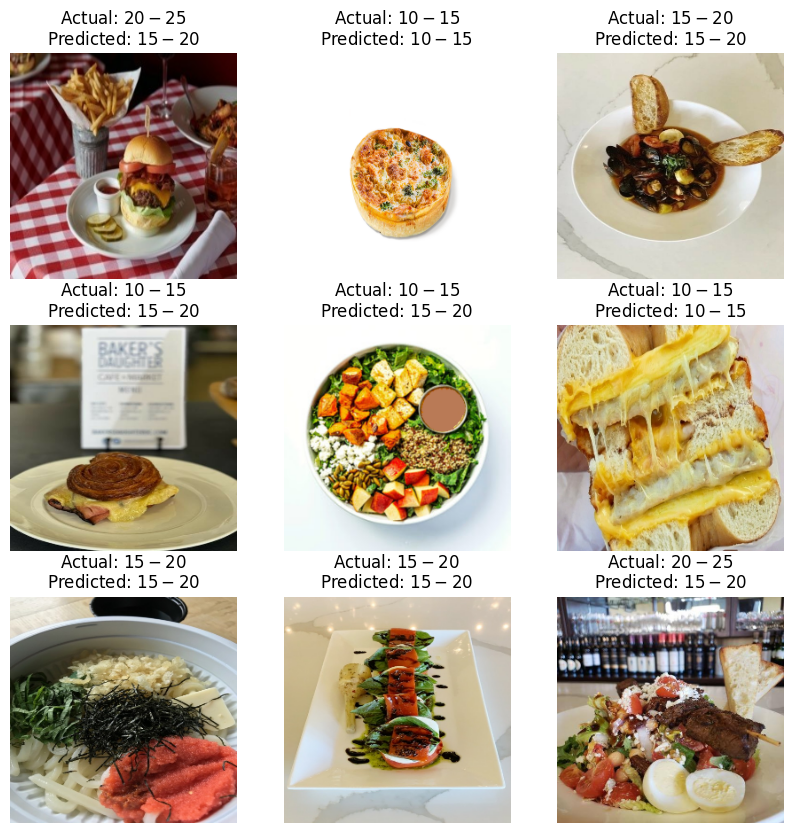

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
for ix, (images, labels) in enumerate(train_ds.take(1)):
    model_preds = model.predict(images)
    model_labels = np.where(model_preds>0, 1, 0)
    for iy in range(9):
        ax = plt.subplot(3, 3, iy + 1)
        plt.imshow(np.array(images[iy]).astype(int))
        plt.title(f"Actual: {label_dict[int(labels[iy])]}\nPredicted: {label_dict[int(model_labels[iy])]}")
        plt.axis("off")

# Save the model

In [ ]:
model.save("models/eatable_model_cat.keras")

INFO:tensorflow:Assets written to: eatable_model/assets


INFO:tensorflow:Assets written to: eatable_model/assets
